**# Core Libraries for this Project**

In [1]:
%pip -q install yfinance pandas numpy matplotlib scikit-learn \
               "stable-baselines3[extra]" sb3-contrib gym "shimmy>=2.0" \
               pypfopt

import torch, numpy as np, random
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


ERROR: Could not find a version that satisfies the requirement pypfopt (from versions: none)
ERROR: No matching distribution found for pypfopt
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


**# Imports**

In [2]:
import math, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import yfinance as yf

%pip -q install "stable-baselines3[extra]" sb3-contrib

import gym
from gym import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.utils import set_random_seed
from sb3_contrib import TRPO
import torch as th
from torch import nn

try:
    from pypfopt import EfficientCVaR
    HAS_PPOPT = True
except Exception:
    HAS_PPOPT = False

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
})

# Reproducibility Factor
seed = 42
np.random.seed(seed); random.seed(seed); th.manual_seed(seed); set_random_seed(seed)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

# **Experiment Config: Dates, Ticker Universe, and Key Hyperparameters**

In [3]:
TRAIN_START, TRAIN_END = "2015-01-01", "2019-12-31"
TEST_START,  TEST_END  = "2020-01-01", "2025-01-01"

# Six asset classes (long-only). You can tweak tickers safely.
EQUITIES   = ["SPY", "QQQ", "IWM", "EFA"]          # US large, tech, small-cap, intl
BONDS      = ["TLT", "IEF", "LQD", "HYG"]          # gov long, gov interm., IG corp, HY
COMMODS    = ["GLD", "DBC"]                        # gold, broad commodities
CRYPTO     = ["BTC-USD", "ETH-USD"]                # crypto
CURRENCIES = ["UUP", "FXE"]                        # USD, EUR proxies
MACRO_TICKERS = ["^VIX", "^GSPC", "^NDX"]          # VIX + S&P + Nasdaq index

ASSET_TICKERS = list(dict.fromkeys(EQUITIES + BONDS + COMMODS + CRYPTO + CURRENCIES))
ALL_TICKERS   = ASSET_TICKERS + MACRO_TICKERS

INITIAL_CAPITAL   = 1_000_000.0
STATE_WINDOW      = 30      # days of features in state
REWARD_RET_WINDOW = 20      # rolling window for Sharpe/Sortino/CVaR
TRADING_COST_BPS  = 5       # per-$ turnover cost


**Download & Clean Price Data (yfinance) + Compute Log Returns**

In [4]:
print("Downloading:", ALL_TICKERS)
raw = yf.download(ALL_TICKERS, start=TRAIN_START, end=TEST_END, auto_adjust=True, progress=False)
assert "Close" in raw, "Expected 'Close' in yfinance output; ensure auto_adjust=True"
close = raw["Close"].dropna(how="all").ffill().dropna()

asset_prices = close[[t for t in ASSET_TICKERS if t in close.columns]].copy()
macro_prices = close[[t for t in MACRO_TICKERS if t in close.columns]].copy()

asset_logret = np.log(asset_prices / asset_prices.shift(1)).fillna(0.0)

display(asset_prices.tail(3))


Downloading: ['SPY', 'QQQ', 'IWM', 'EFA', 'TLT', 'IEF', 'LQD', 'HYG', 'GLD', 'DBC', 'BTC-USD', 'ETH-USD', 'UUP', 'FXE', '^VIX', '^GSPC', '^NDX']


Ticker,SPY,QQQ,IWM,EFA,TLT,IEF,LQD,HYG,GLD,DBC,BTC-USD,ETH-USD,UUP,FXE
Date,,,,,,,,,,,,,,
2024-12-29,589.841553,520.593018,220.654343,74.814346,83.713272,88.942139,102.347595,74.507278,241.399994,21.080000,93530.226562,3349.513428,29.260000,95.329269
2024-12-30,583.110535,513.669189,218.957672,74.322861,84.386055,89.463745,102.789032,74.611618,240.630005,21.270000,92643.210938,3356.392578,29.290001,95.081757
2024-12-31,580.989136,509.305695,219.235519,74.322861,83.934326,89.299530,102.529922,74.602127,242.130005,21.379999,93429.203125,3332.531738,29.420000,94.705566


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


**Feature Engineering: Technical Indicators + Macro Proxies + Alignment**

In [5]:
def rsi(prices: pd.Series, period=14):
    delta = prices.diff()
    up = delta.clip(lower=0.0); down = -delta.clip(upper=0.0)
    roll_up = up.rolling(period).mean()
    roll_down = down.rolling(period).mean()
    rs = roll_up / (roll_down + 1e-8)
    return 100 - (100 / (1 + rs))

def ema(x: pd.Series, span: int):
    return x.ewm(span=span, adjust=False).mean()

feat = {}
rets_pct = asset_prices.pct_change()
logret   = asset_logret

def bollinger_pct_b(px, window=20, n=2):
    ma = px.rolling(window).mean()
    sd = px.rolling(window).std()
    upper, lower = ma + n*sd, ma - n*sd
    return (px - lower) / (upper - lower + 1e-8)

def stochastic_k(px, window=14):
    # With close-only data, approximate using rolling min/max of close
    low  = px.rolling(window).min()
    high = px.rolling(window).max()
    return 100 * (px - low) / (high - low + 1e-8)

def stochastic_d(k, window=3):
    return k.rolling(window).mean()

def williams_r(px, window=14):
    low  = px.rolling(window).min()
    high = px.rolling(window).max()
    return -100 * (high - px) / (high - low + 1e-8)

# market refs for cross-asset features
spy_ret = logret["SPY"] if "SPY" in logret.columns else rets_pct.mean(axis=1)

for t in ASSET_TICKERS:
    px = asset_prices[t]
    lr = logret[t]
    r  = rets_pct[t]

    # basic trend/vol
    ma20  = px.rolling(20).mean() / (px + 1e-8)
    ma60  = px.rolling(60).mean() / (px + 1e-8)
    vol20 = r.rolling(20).std().fillna(0.0)

    rsi14 = (rsi(px, 14) / 100.0).fillna(0.5)
    macd  = (ema(px, 12) - ema(px, 26)) / (px + 1e-8)
    macds = (ema(ema(px, 12) - ema(px, 26), 9)) / (px + 1e-8)
    bb    = bollinger_pct_b(px).fillna(0.5)
    k     = stochastic_k(px).fillna(50.0)
    d     = stochastic_d(k).fillna(50.0)
    wr    = (williams_r(px) / -100.0).fillna(0.5)  # scale 0..1 (roughly)

    skew20 = r.rolling(20).skew().fillna(0.0)
    kurt20 = r.rolling(20).kurt().fillna(0.0)

    corr60 = r.rolling(60).corr(spy_ret).fillna(0.0)
    beta60 = (r.rolling(60).cov(spy_ret) / (spy_ret.rolling(60).var() + 1e-8)).fillna(0.0)

    mom60  = (px / px.shift(60) - 1.0).fillna(0.0)
    rank_cs = mom60.rank(axis=0, pct=True)

    vol_q1 = rets_pct.rolling(20).std().quantile(0.33, axis=1)
    vol_q2 = rets_pct.rolling(20).std().quantile(0.66, axis=1)
    vol = vol20
    low_bucket  = ((vol <= vol_q1).astype(float)).fillna(0.0)
    high_bucket = ((vol >= vol_q2).astype(float)).fillna(0.0)
    mid_bucket  = (1.0 - low_bucket - high_bucket).clip(0, 1)

    feat[(t, "ret")]      = lr
    feat[(t, "ma20")]     = ma20
    feat[(t, "ma60")]     = ma60
    feat[(t, "vol20")]    = vol20
    feat[(t, "rsi14")]    = rsi14
    feat[(t, "macd")]     = macd
    feat[(t, "macdsig")]  = macds
    feat[(t, "bb%")]      = bb
    feat[(t, "%K")]       = k / 100.0
    feat[(t, "%D")]       = d / 100.0
    feat[(t, "wr")]       = wr
    feat[(t, "skew20")]   = skew20
    feat[(t, "kurt20")]   = kurt20
    feat[(t, "corr60SPY")] = corr60
    feat[(t, "beta60SPY")] = beta60
    feat[(t, "rankCS60")]  = rank_cs

    feat[(t, "volLow")]   = low_bucket
    feat[(t, "volMid")]   = mid_bucket
    feat[(t, "volHigh")]  = high_bucket

if "^VIX" in macro_prices.columns:
    vix = macro_prices["^VIX"]
    feat[("MACRO", "vix")] = vix
    feat[("MACRO", "vix_ret")] = np.log(vix / vix.shift(1)).fillna(0.0)
if "^GSPC" in macro_prices.columns:
    spx = macro_prices["^GSPC"]
    feat[("MACRO", "spx")] = spx
    feat[("MACRO", "spx_ret")] = np.log(spx / spx.shift(1)).fillna(0.0)
if "^NDX" in macro_prices.columns:
    ndx = macro_prices["^NDX"]
    feat[("MACRO", "ndx")] = ndx
    feat[("MACRO", "ndx_ret")] = np.log(ndx / ndx.shift(1)).fillna(0.0)

features = pd.DataFrame(feat).dropna().astype(float)

asset_prices = asset_prices.loc[features.index]
asset_logret = asset_logret.loc[features.index]

print("features shape:", features.shape)


features shape: (2551, 272)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


**Train/Test Split + Feature Scaling (StandardScaler)**

In [6]:
train_mask = (features.index >= TRAIN_START) & (features.index <= TRAIN_END)
test_mask  = (features.index >= TEST_START)  & (features.index <= TEST_END)

train_features = features.loc[train_mask]
test_features  = features.loc[test_mask]

train_prices = asset_prices.loc[train_mask]
test_prices  = asset_prices.loc[test_mask]

train_logret = asset_logret.loc[train_mask]
test_logret  = asset_logret.loc[test_mask]

scaler = StandardScaler()
scaler.fit(train_features.values)

train_feat_scaled = pd.DataFrame(scaler.transform(train_features.values),
                                 index=train_features.index, columns=train_features.columns)
test_feat_scaled  = pd.DataFrame(scaler.transform(test_features.values),
                                 index=test_features.index, columns=test_features.columns)

display(train_feat_scaled.tail(2))


SPY                                                    \
                 ret      ma20      ma60     vol20     rsi14      macd   
Date                                                                     
2019-12-30 -0.739051 -0.146831 -0.606684 -1.036744  0.686009  0.816572   
2019-12-31  0.273609 -0.200697 -0.656521 -1.038991  0.806838  0.762903   

                                                    ...       FXE            \
             macdsig       bb%        %K        %D  ...  rankCS60    volLow   
Date                                                ...                       
2019-12-30  0.918775  0.127134 -0.090983  0.596735  ...  0.755064  0.543295   
2019-12-31  0.898857  0.290484  0.332793  0.397373  ...  0.739952  0.543295   

                                  MACRO                                \
             volMid   volHigh       vix   vix_ret       spx   spx_ret   
Date                                                                    
2019-12-30 -0.53476 -0.074536 -0.289008  1.331882  2.514616 -0.767443   
2019-12-31 -0.53476 -0.074536 -0.543559 -0.997086  2.575577  0.345998   

                                
                 ndx   ndx_ret  
Date                            
2019-12-30  2.530011 -0.711951  
2019-12-31  2.572260  0.221822  

[2 rows x 272 columns]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


**ustom Gym Environment: Multi-Asset Portfolio Env (State/Action/Reward)**

In [7]:
class MultiAssetPortfolioEnv(gym.Env):
    """
    Multi-asset, long-only portfolio environment with rich (scaled) features
    and risk-aware reward shaping.

    State: concat( last `window` rows of features, current weights, normalized value )
    Action: R^(N+1) -> softmax -> weights (>=0, sum=1) for [CASH + risky assets]
    Reward: log return + Sharpe/Sortino bonuses - drawdown/turnover penalties + entropy
    """
    metadata = {"render.modes": ["human"]}

    def __init__(self, prices_df, logret_df, feat_df, window=30,
                 trading_cost_bps=5, initial_value=1_000_000.0, ret_window=20):
        super().__init__()
        assert len(prices_df) == len(logret_df) == len(feat_df)
        self.prices  = prices_df
        self.logret  = logret_df
        self.features = feat_df
        self.dates   = prices_df.index
        self.assets  = list(prices_df.columns)
        self.n_risky = len(self.assets)
        self.n_assets = self.n_risky + 1

        self.window = window
        self.trading_cost = trading_cost_bps / 10_000
        self.initial_value = float(initial_value)
        self.ret_window = ret_window

        self.feature_dim = self.features.shape[1]
        obs_dim = self.window * self.feature_dim + self.n_assets + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Box(low=-10.0, high=10.0,
                                       shape=(self.n_assets,), dtype=np.float32)
        self._max_step = len(self.prices) - 1
        self.reset()

    def _get_obs(self):
        s, e = self.current_step - self.window, self.current_step
        win = self.features.iloc[s:e].values
        obs = np.concatenate([
            win.flatten().astype(np.float32),
            self.weights.astype(np.float32),
            np.array([self.portfolio_value / self.initial_value], dtype=np.float32)
        ])
        return obs

    def reset(self):
        self.current_step = self.window
        self.portfolio_value = self.initial_value
        self.weights = np.zeros(self.n_assets, dtype=np.float32)
        self.weights[0] = 1.0
        self.prev_weights = self.weights.copy()
        self.daily_log = []
        self.peak_value = self.initial_value
        return self._get_obs()

    def step(self, action):
        prev_val = self.portfolio_value
        a = np.clip(np.asarray(action, dtype=np.float32).flatten(), -10, 10)
        exps = np.exp(a - a.max())
        new_w = exps / exps.sum()

        # Turnover / transaction cost
        turnover = float(np.abs(new_w - self.weights).sum())
        cost = self.trading_cost * turnover * self.portfolio_value
        self.portfolio_value -= cost

        # Apply asset log-returns for this day (cash=0)
        risky = self.logret.iloc[self.current_step].values
        asset_lr = np.concatenate([[0.0], risky])
        gross = float(np.exp(np.dot(new_w, asset_lr)))
        self.portfolio_value *= gross

        log_ret = float(np.log(self.portfolio_value / prev_val + 1e-12))
        self.daily_log.append(log_ret)

        # Rolling Sharpe/Sortino bonuses
        if len(self.daily_log) >= self.ret_window:
            recent = np.array(self.daily_log[-self.ret_window:])
            mu = float(recent.mean())
            sigma = float(recent.std() + 1e-6)
            sharpe = mu / sigma
            downside = recent[recent < 0]
            sortino = mu / float(downside.std() + 1e-6) if len(downside) else 0.0

            # Tail risk (CVaR-like) penalty (5% tail on recent)
            var5 = float(np.percentile(recent, 5))
            tail = recent[recent <= var5]
            cvar5 = float(tail.mean()) if len(tail) else 0.0  # negative
            cvar_pen = -cvar5  # higher penalty if heavy negative tail
        else:
            sharpe, sortino, cvar_pen = 0.0, 0.0, 0.0

        self.peak_value = max(self.peak_value, self.portfolio_value)
        drawdown = max(0.0, (self.peak_value - self.portfolio_value) / (self.peak_value + 1e-6))

        entropy = -float(np.sum(new_w * np.log(new_w + 1e-8)))

        hhi = float(np.sum(new_w**2))
        hhi_excess = max(0.0, hhi - 1.0/self.n_assets)

        change_l1 = float(np.abs(new_w - self.weights).sum())
        change_l2 = float(np.sum((new_w - self.weights)**2))

        try:
            vix_scaled = float(self.features.iloc[self.current_step][('MACRO','vix')])
            risk_amp = 1.0 + 0.25 * max(0.0, vix_scaled)
        except Exception:
            risk_amp = 1.0

        reward = (
            1.0 * log_ret +
            0.30 * sharpe +
            0.20 * sortino -
            (0.05 * risk_amp) * drawdown -
            0.06 * change_l1 - 0.02 * change_l2 +
            0.04 * entropy -
            0.03 * hhi_excess -
            0.04 * cvar_pen
        )
        reward = float(np.clip(reward, -5.0, 5.0))


        self.prev_weights = self.weights.copy()
        self.weights = new_w
        self.current_step += 1
        done = self.current_step >= self._max_step

        obs = self._get_obs()
        info = {
            "portfolio_value": float(self.portfolio_value),
            "weights": self.weights.copy(),
            "date": self.dates[self.current_step - 1]
        }
        return obs, reward, done, info

    def render(self, mode="human"):
        labels = ["CASH"] + self.assets
        print(self.dates[self.current_step-1], f"value={self.portfolio_value:.2f}",
              dict(zip(labels, np.round(self.weights, 3))))


**Create Train/Test Environments + Vectorize (DummyVecEnv)**

In [8]:
%pip -q install 'shimmy>=2.0'

train_env = MultiAssetPortfolioEnv(
    prices_df=train_prices,
    logret_df=train_logret,
    feat_df=train_feat_scaled,
    window=STATE_WINDOW,
    trading_cost_bps=TRADING_COST_BPS,
    initial_value=INITIAL_CAPITAL,
    ret_window=REWARD_RET_WINDOW,
)
test_env = MultiAssetPortfolioEnv(
    prices_df=test_prices,
    logret_df=test_logret,
    feat_df=test_feat_scaled,
    window=STATE_WINDOW,
    trading_cost_bps=TRADING_COST_BPS,
    initial_value=INITIAL_CAPITAL,
    ret_window=REWARD_RET_WINDOW,
)

vec_train_env = DummyVecEnv([lambda: train_env])

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


**VecNormalize Wrapper (Reward Normalization Settings)**

In [9]:
from stable_baselines3.common.vec_env import VecNormalize

vec_train_env = VecNormalize(vec_train_env, norm_obs=False, norm_reward=True, clip_obs=10.0)


**TRPO Setup + Training (Policy Network + TRPO Hyperparameters)**

In [10]:
from stable_baselines3.common.utils import get_device

policy_kwargs = dict(
    activation_fn=nn.SiLU,
    net_arch=[dict(pi=[1024, 512, 256],
                   vf=[1024, 512, 256])],
    ortho_init=False,
)

trpo = TRPO(
    "MlpPolicy",
    vec_train_env,
    learning_rate=3e-4,
    n_steps=4096,
    batch_size=512,
    gamma=0.99,
    gae_lambda=0.95,
    target_kl=0.008,
    cg_damping=0.2,
    policy_kwargs=policy_kwargs,
    normalize_advantage=True,
    verbose=1,
    seed=seed,
    device=get_device("auto"),
)

# Hi hope you've enjoyed our project so far! If you are running this start at 200k; for best results go 600k–1M timesteps
trpo.learn(total_timesteps=200_000)


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


Using cuda device


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run TRPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed

-----------------------------
| time/              |      |
|    fps             | 437  |
|    iterations      | 1    |
|    time_elapsed    | 9    |
|    total_timesteps | 4096 |
-----------------------------
----------------------------------------
| time/                     |          |
|    fps                    | 423      |
|    iterations             | 2        |
|    time_elapsed           | 19       |
|    total_timesteps        | 8192     |
| train/                    |          |
|    explained_variance     | 0.00125  |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00108  |
|    learning_rate          | 0.0003   |
|    n_updates              | 1        |
|    policy_objective       | 0.053    |
|    std                    | 1        |
|    value_loss             | 0.175    |
----------------------------------------
----------------------------------------
| time/                     |          |
|    fps                    | 420      |
|    iterat

**Run TRPO on Test Set + Collect Portfolio Values and Weights**

In [11]:
def run_policy(env, model):
    obs = env.reset()
    done = False
    vals, dates, ws = [], [], []
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        vals.append(info["portfolio_value"])
        dates.append(info["date"])
        ws.append(info["weights"])
    return pd.Series(vals, index=pd.to_datetime(dates)), np.vstack(ws)

trpo_values, trpo_weights = run_policy(test_env, trpo)
trpo_values.head()


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,0
2020-01-31,993744.095150
2020-02-01,994362.188418
2020-02-02,994606.340685
2020-02-03,995557.216867
2020-02-04,997856.448449


# Baseline + Metrics

In [12]:
import math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

INITIAL_CAPITAL = 1_000_000.0

def bh_series(prices: pd.Series, initial=INITIAL_CAPITAL):
    base = prices.iloc[0]
    return initial * (prices / base)

def equal_weight_bh(prices_df: pd.DataFrame, initial=INITIAL_CAPITAL):
    rel = prices_df / prices_df.iloc[0]
    return initial * rel.mean(axis=1)

def portfolio_value_from_weights(prices_df: pd.DataFrame, w: np.ndarray, initial=INITIAL_CAPITAL):
    rel = prices_df / prices_df.iloc[0]
    return initial * (rel @ w)

def mvo_max_sharpe(prices_df_train: pd.DataFrame, prices_df_test: pd.DataFrame, rf=0.0):
    rets = prices_df_train.pct_change().dropna()
    mu, cov = rets.mean().values, rets.cov().values
    n = len(mu)
    bounds = [(0.0, 1.0)] * n
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0})
    def neg_sharpe(w):
        r = w @ mu * 252
        v = math.sqrt(w @ cov @ w) * math.sqrt(252)
        return - (r - rf) / (v + 1e-12)
    w0 = np.ones(n) / n
    res = minimize(neg_sharpe, w0, bounds=bounds, constraints=cons)
    w = res.x if res.success else w0
    return portfolio_value_from_weights(prices_df_test, w)

def cvar_min(prices_df_train: pd.DataFrame, prices_df_test: pd.DataFrame, alpha=0.05):
    try:
        from pypfopt import EfficientCVaR
        rets = prices_df_train.pct_change().dropna()
        ec = EfficientCVaR(rets, beta=1-alpha)
        w = ec.min_cvar()
        w = np.array(list(w.values())); w = w / w.sum()
        return portfolio_value_from_weights(prices_df_test, w)
    except Exception:
        vol = prices_df_train.pct_change().dropna().std()
        w = (1 / (vol + 1e-8)); w = (w / w.sum()).values
        return portfolio_value_from_weights(prices_df_test, w)

def risk_parity_invvol(prices_df_train: pd.DataFrame, prices_df_test: pd.DataFrame):
    vol = prices_df_train.pct_change().dropna().std()
    w = (1 / (vol + 1e-8)); w = (w / w.sum()).values
    return portfolio_value_from_weights(prices_df_test, w)

def metrics(series: pd.Series, freq=252, rf=0.0):
    rets = series.pct_change().dropna()
    cum = series.iloc[-1] / series.iloc[0] - 1
    ann = (1 + cum) ** (freq / len(rets)) - 1
    vol = rets.std() * math.sqrt(freq)
    downside = rets[rets < 0]
    sortino = (ann - rf) / (downside.std() * math.sqrt(freq) + 1e-12) if len(downside) else np.nan
    sharpe  = (ann - rf) / (vol + 1e-12) if vol > 0 else np.nan
    runmax = series.cummax()
    dd = ((series - runmax) / runmax).min()
    return {
        "Cumulative Return": cum,
        "Annualized Return": ann,
        "Annualized Volatility": vol,
        "Sharpe Ratio": sharpe,
        "Sortino Ratio": sortino,
        "Max Drawdown": dd,
    }

test_prices_aligned = test_prices.loc[trpo_values.index]

curves = {"TRPO": trpo_values}
if "SPY" in test_prices_aligned.columns:
    curves["Buy & Hold SPY"] = bh_series(test_prices_aligned["SPY"])
curves["Equal-Weight BH"]   = equal_weight_bh(test_prices_aligned)
curves["MVO (Max Sharpe)"]  = mvo_max_sharpe(train_prices, test_prices_aligned)
curves["CVaR Min"]          = cvar_min(train_prices, test_prices_aligned)
curves["Risk Parity (InvVol)"] = risk_parity_invvol(train_prices, test_prices_aligned)

results = {name: metrics(series) for name, series in curves.items()}
metrics_df = pd.DataFrame(results).T

styled = metrics_df.style.format({
    "Cumulative Return": "{:.2%}",
    "Annualized Return": "{:.2%}",
    "Annualized Volatility": "{:.2%}",
    "Sharpe Ratio": "{:.2f}",
    "Sortino Ratio": "{:.2f}",
    "Max Drawdown": "{:.2%}",
}).set_table_styles(
    [
        {"selector": "th", "props": [("font-size", "12pt"), ("text-align", "center")]},
        {"selector": "td", "props": [("font-size", "11pt"), ("text-align", "center")]},
    ]
)
display(styled)


,Cumulative Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown
TRPO,73.74%,8.06%,12.29%,0.66,0.80,-23.91%
Buy & Hold SPY,97.20%,10.00%,17.53%,0.57,0.58,-33.72%
Equal-Weight BH,220.33%,17.76%,31.67%,0.56,0.73,-58.16%
MVO (Max Sharpe),15.41%,2.03%,1.66%,1.22,1.38,-2.39%
CVaR Min,40.16%,4.85%,9.18%,0.53,0.66,-25.44%
Risk Parity (InvVol),40.16%,4.85%,9.18%,0.53,0.66,-25.44%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Plots

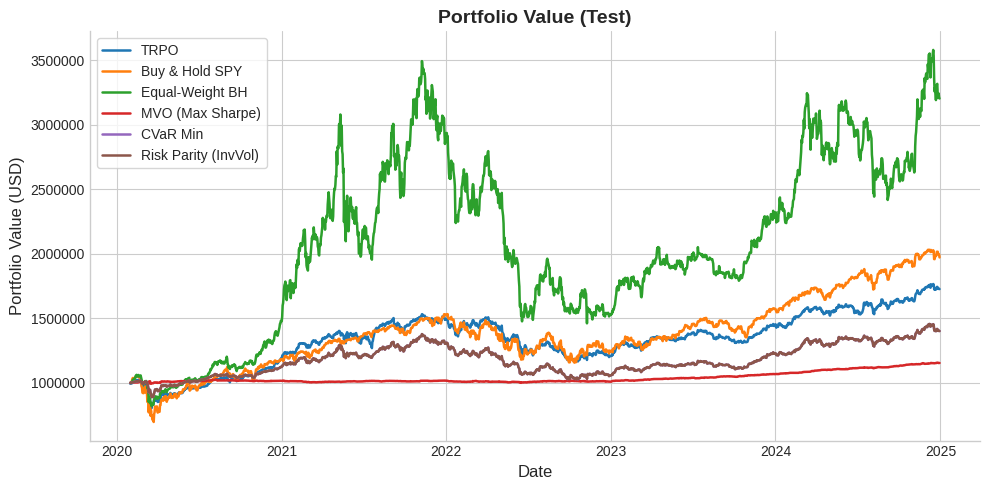

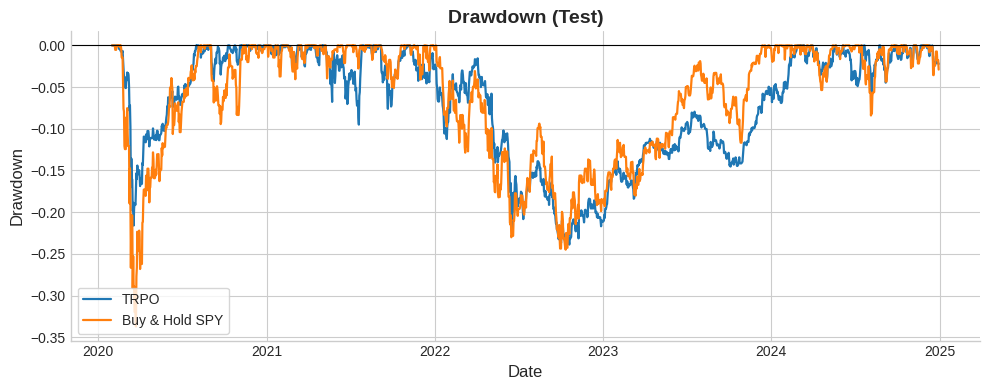

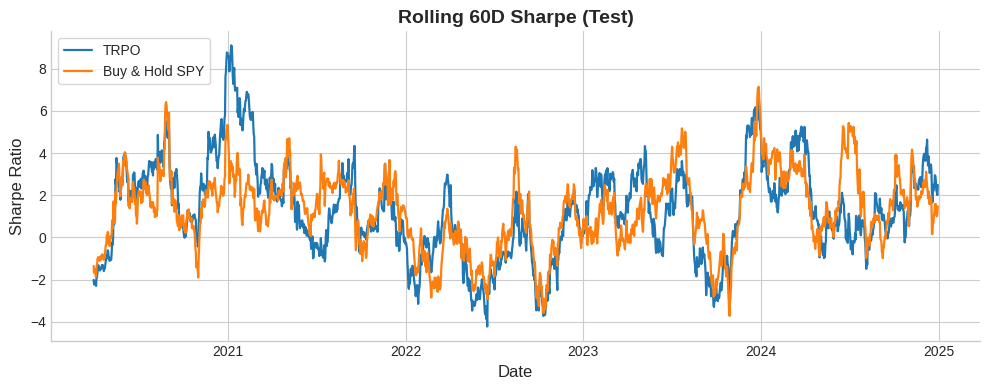

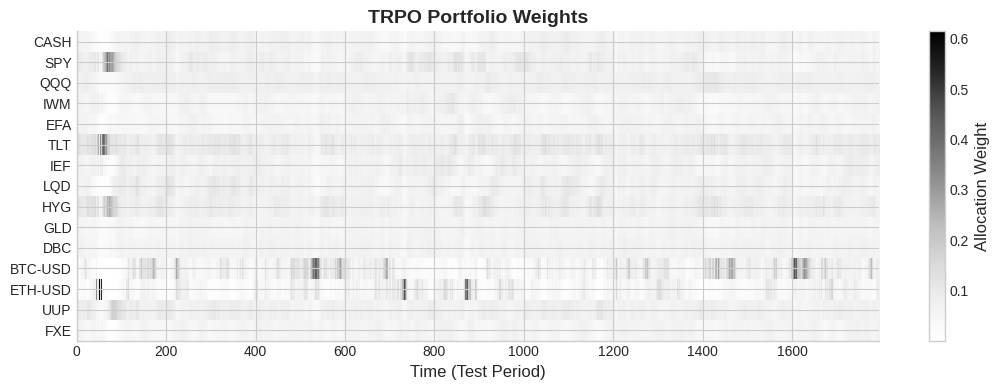

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [13]:
# ----- plots (slide-ready) -----
def plot_equity(curves: dict, title="Portfolio Value (Test)"):
    fig, ax = plt.subplots(figsize=(10,5))
    for name, s in curves.items():
        ax.plot(s.index, s.values, label=name, linewidth=1.8)
    ax.set_title(title, weight="bold")
    ax.set_xlabel("Date"); ax.set_ylabel("Portfolio Value (USD)")
    ax.ticklabel_format(axis="y", style="plain")
    ax.legend(loc="upper left", frameon=True)
    fig.tight_layout(); plt.show()

def drawdown(s: pd.Series):
    return (s - s.cummax()) / s.cummax()

def plot_drawdown(curves: dict, title="Drawdown (Test)"):
    fig, ax = plt.subplots(figsize=(10,4))
    for name, s in curves.items():
        dd = drawdown(s)
        ax.plot(dd.index, dd.values, label=name, linewidth=1.6)
    ax.set_title(title, weight="bold")
    ax.set_xlabel("Date"); ax.set_ylabel("Drawdown")
    ax.axhline(0, color="black", linewidth=0.8)
    ax.legend(loc="lower left", frameon=True)
    fig.tight_layout(); plt.show()

def rolling_sharpe(s: pd.Series, window=60, freq=252):
    rets = s.pct_change()
    mu = rets.rolling(window).mean()
    sd = rets.rolling(window).std()
    return (mu / (sd + 1e-12)) * math.sqrt(freq)

def plot_rolling_sharpe(curves: dict, title="Rolling 60D Sharpe (Test)"):
    fig, ax = plt.subplots(figsize=(10,4))
    for name, s in curves.items():
        rs = rolling_sharpe(s)
        ax.plot(rs.index, rs.values, label=name, linewidth=1.6)
        ax.set_title(title, weight="bold")
    ax.set_xlabel("Date"); ax.set_ylabel("Sharpe Ratio")
    ax.legend(loc="upper left", frameon=True)
    fig.tight_layout(); plt.show()

plot_equity(curves)
plot_drawdown({"TRPO": curves["TRPO"], "Buy & Hold SPY": curves.get("Buy & Hold SPY", curves["TRPO"])})
plot_rolling_sharpe({"TRPO": curves["TRPO"], "Buy & Hold SPY": curves.get("Buy & Hold SPY", curves["TRPO"])})

try:
    asset_labels = ["CASH"] + list(test_prices_aligned.columns)
    fig, ax = plt.subplots(figsize=(11,4))
    im = ax.imshow(trpo_weights.T, aspect="auto", interpolation="nearest")
    ax.set_yticks(range(len(asset_labels))); ax.set_yticklabels(asset_labels)
    ax.set_xlabel("Time (Test Period)"); ax.set_title("TRPO Portfolio Weights", weight="bold")
    cbar = fig.colorbar(im, ax=ax); cbar.set_label("Allocation Weight")
    fig.tight_layout(); plt.show()
except Exception:
    pass


**Weights Heatmap Plot (Dedicated Function)**

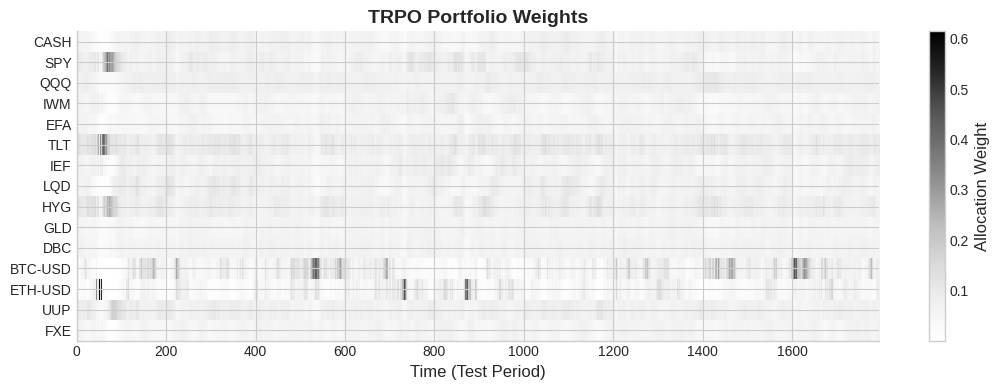

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [14]:
asset_labels = ["CASH"] + list(test_prices.columns)

def plot_weight_heatmap(weights: np.ndarray, index: pd.DatetimeIndex, labels: list, title="TRPO Portfolio Weights"):
    fig, ax = plt.subplots(figsize=(11,4))
    im = ax.imshow(weights.T, aspect="auto", interpolation="nearest")
    ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
    ax.set_xlabel("Time (Test Period)"); ax.set_title(title, weight="bold")
    cbar = fig.colorbar(im, ax=ax); cbar.set_label("Allocation Weight")
    fig.tight_layout(); plt.show()

plot_weight_heatmap(trpo_weights, trpo_values.index, asset_labels)


# Extra Calcs

In [15]:
import numpy as np, pandas as pd, math

def slice_metrics(series, label):
    rets = series.pct_change().dropna()
    ann = (1 + (series.iloc[-1]/series.iloc[0] - 1))**(252/len(rets)) - 1
    vol = rets.std()*np.sqrt(252)
    dd  = ((series-series.cummax())/series.cummax()).min()
    sharpe = ann/(vol+1e-12) if vol>0 else np.nan
    return dict(label=label, ann=ann, vol=vol, sharpe=sharpe, maxDD=dd)

wf = []
idx = trpo_values.index
splits = [
    (idx[idx.year<=2021], "2020–2021"),
    (idx[(idx.year==2022)], "2022"),
    (idx[(idx.year==2023)], "2023"),
    (idx[(idx.year>=2024)], "2024–2025"),
]
for sub_idx, name in splits:
    if len(sub_idx)<30: continue
    wf.append(slice_metrics(trpo_values.loc[sub_idx], f"TRPO {name}"))
    if "Buy & Hold SPY" in curves:
        wf.append(slice_metrics(curves["Buy & Hold SPY"].loc[sub_idx], f"SPY {name}"))
pd.DataFrame(wf)

rng = np.random.default_rng(0)

def stationary_bootstrap(x, B=2000, p=0.1):
    x = np.asarray(x)
    n = len(x)
    out = np.empty((B, n))
    starts = rng.integers(0, n, size=B)
    for b in range(B):
        i = starts[b]
        for t in range(n):
            out[b, t] = x[i]
            if rng.random() < p:
                i = rng.integers(0, n)
            else:
                i = (i+1) % n
    return out

def sharpe_ci(series, alpha=0.05):
    r = series.pct_change().dropna().values
    B = stationary_bootstrap(r)
    sr = (B.mean(axis=1) / (B.std(axis=1)+1e-12)) * np.sqrt(252)
    lo, hi = np.quantile(sr, [alpha/2, 1-alpha/2])
    return lo, hi

trpo_lo, trpo_hi = sharpe_ci(trpo_values)
print(f"TRPO Sharpe 95% CI: [{trpo_lo:.2f}, {trpo_hi:.2f}]")

if "Buy & Hold SPY" in curves:
    spy_r = curves["Buy & Hold SPY"].pct_change().dropna().values
    trpo_r = trpo_values.pct_change().dropna().values
    B = stationary_bootstrap(trpo_r)
    sr_trpo = (B.mean(axis=1)/(B.std(axis=1)+1e-12))*np.sqrt(252)
    B2 = stationary_bootstrap(spy_r)
    sr_spy  = (B2.mean(axis=1)/(B2.std(axis=1)+1e-12))*np.sqrt(252)
    p = (sr_trpo <= sr_spy).mean()
    print(f"P(TRPO Sharpe <= SPY) ~ {p:.2f}")


TRPO Sharpe 95% CI: [-0.09, 1.53]
P(TRPO Sharpe <= SPY) ~ 0.47


# Turnover, HHI and Avg Cash Checks

In [16]:
weights = pd.DataFrame(trpo_weights, index=trpo_values.index, columns=["CASH"] + list(test_prices.columns))
turnover = (weights.diff().abs().sum(axis=1)).mean()
hhi_avg  = (weights.pow(2).sum(axis=1)).mean()
avg_cash = weights["CASH"].mean()
print(f"Avg turnover {turnover:.3f}, Avg HHI {hhi_avg:.3f}, Avg cash {avg_cash:.2%}")


Avg turnover 0.074, Avg HHI 0.079, Avg cash 6.08%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Export Precomputed JSON file for Gold Rush Game

In [22]:
import json
import numpy as np

GAME_TICKERS = ASSET_TICKERS

idx = trpo_values.index

game_logret = test_logret[GAME_TICKERS].loc[idx]
asset_returns = np.exp(game_logret.values) - 1.0

trpo_data = {
    "dates": [d.strftime("%Y-%m-%d") for d in idx],
    "tickers": GAME_TICKERS,
    "trpoPortfolio": trpo_values.tolist(),
    "trpoWeights": trpo_weights.tolist(),
    "assetReturns": asset_returns.tolist(),
}

with open("trpo3.json", "w") as f:
    json.dump(trpo_data, f)

from google.colab import files
files.download("trpo3.json")


<IPython.core.display.Javascript object>

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


<IPython.core.display.Javascript object>